# Where There’s Smoke, There Might Be Fire
## Introduction

A smoke detector is an electronic device used to sense the presence of smoke, often sounding an alarm when it senses a certain level of particle concentration in a room's air. The [dataset we'll be using](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset) contains nearly 60,000 observations from a "smart" smoke detector, which records measurements from many different sensors. These include measurements related to particle concentration and type, air-related parameters, and environmental parameters, which were observed both with and without an active fire nearby. For this analysis, we will only focus on three of these variables: air temperature (degrees Celsius), air humidity (percentage), and raw molecular hydrogen (unitless).


Our goal is to train a model using this dataset to answer the following predictive question: can we use a reading from a smoke detector to accurately predict whether or not there is an active fire?

## Preliminary Exploratory Data Analysis

In [1]:
library(tidyverse)
library(tidymodels)
set.seed(12345)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# Reading and wrangling
# GitHub is easier to download from than Kaggle, so we are skipping
# the middleman and downloading from the original author of the data
smoke_data <- read_csv("https://raw.githubusercontent.com/Blatts01/ai-smokedetector/main/data/final.csv") |>
    rename_with(make.names) |> # Remove messy characters from column names
    select(Temperature.C., Humidity..., Raw.H2, Fire.Alarm)

# Better column names
colnames(smoke_data) = c("temp", "humidity", "raw_h2", "fire")   

smoke_data$fire[smoke_data$fire == 1] <- "Fire"
smoke_data$fire[smoke_data$fire == 0] <- "No Fire"

smoke_data <- mutate(smoke_data, fire = as_factor(fire))

# Split into training and testing data
smoke_split <- initial_split(smoke_data, prop = 0.01, strata = fire)
smoke_train <- training(smoke_split)
smoke_test <- testing(smoke_split)

Rows: 62630 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (15): Temperature[C], Humidity[%], TVOC[ppb], eCO2[ppm], Raw H2, Raw Eth...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# Preliminary analysis

# Counts of each class:
fire_alarm_counts <- smoke_train |>
    group_by(fire) |>
    summarise(n())
fire_alarm_counts

# Means of measured quantities:
fire_alarm_means <- smoke_train |>
    select(-fire) |>
    map_df(mean)
fire_alarm_means

fire,n()
<fct>,<int>
No Fire,178
Fire,447


temp,humidity,raw_h2
<dbl>,<dbl>,<dbl>
16.51318,48.09466,12937.75


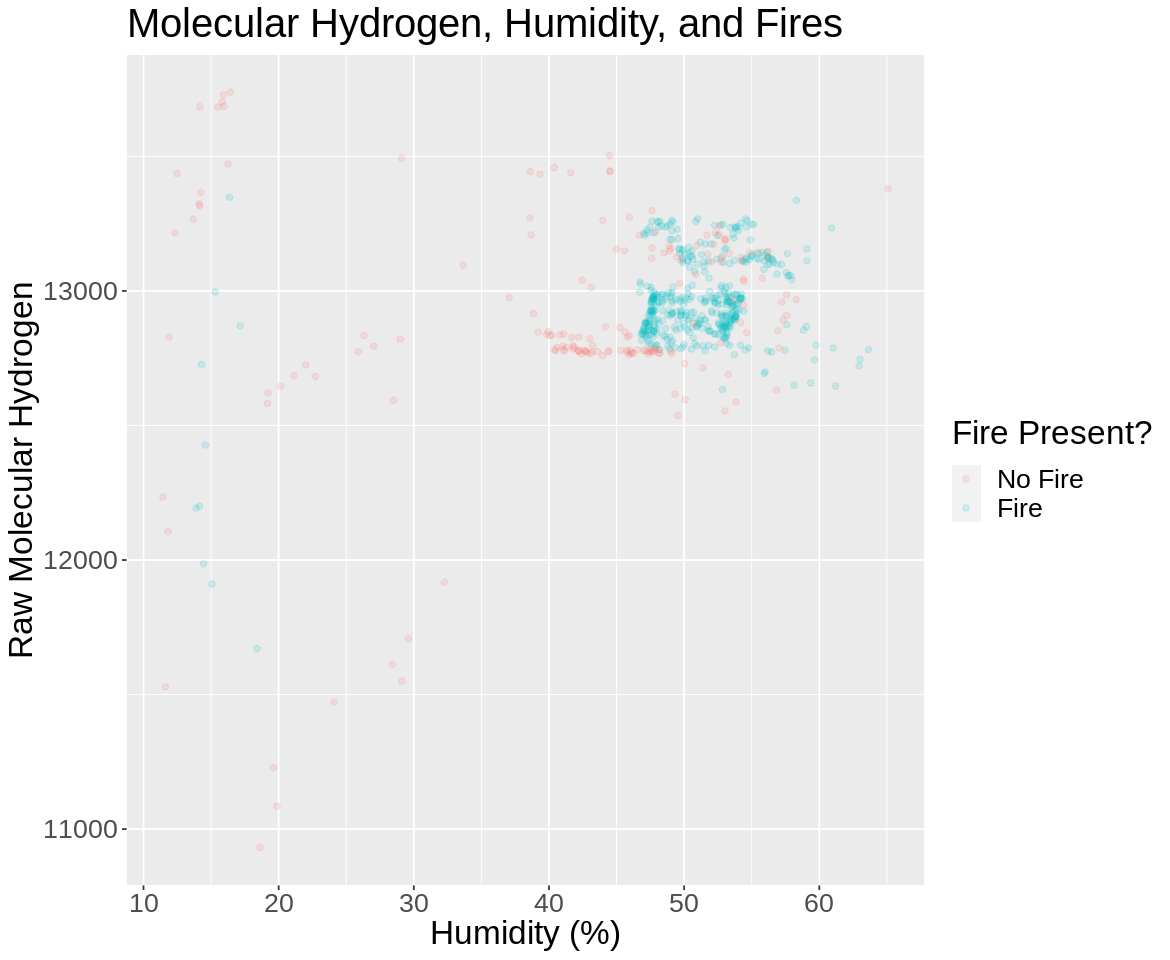

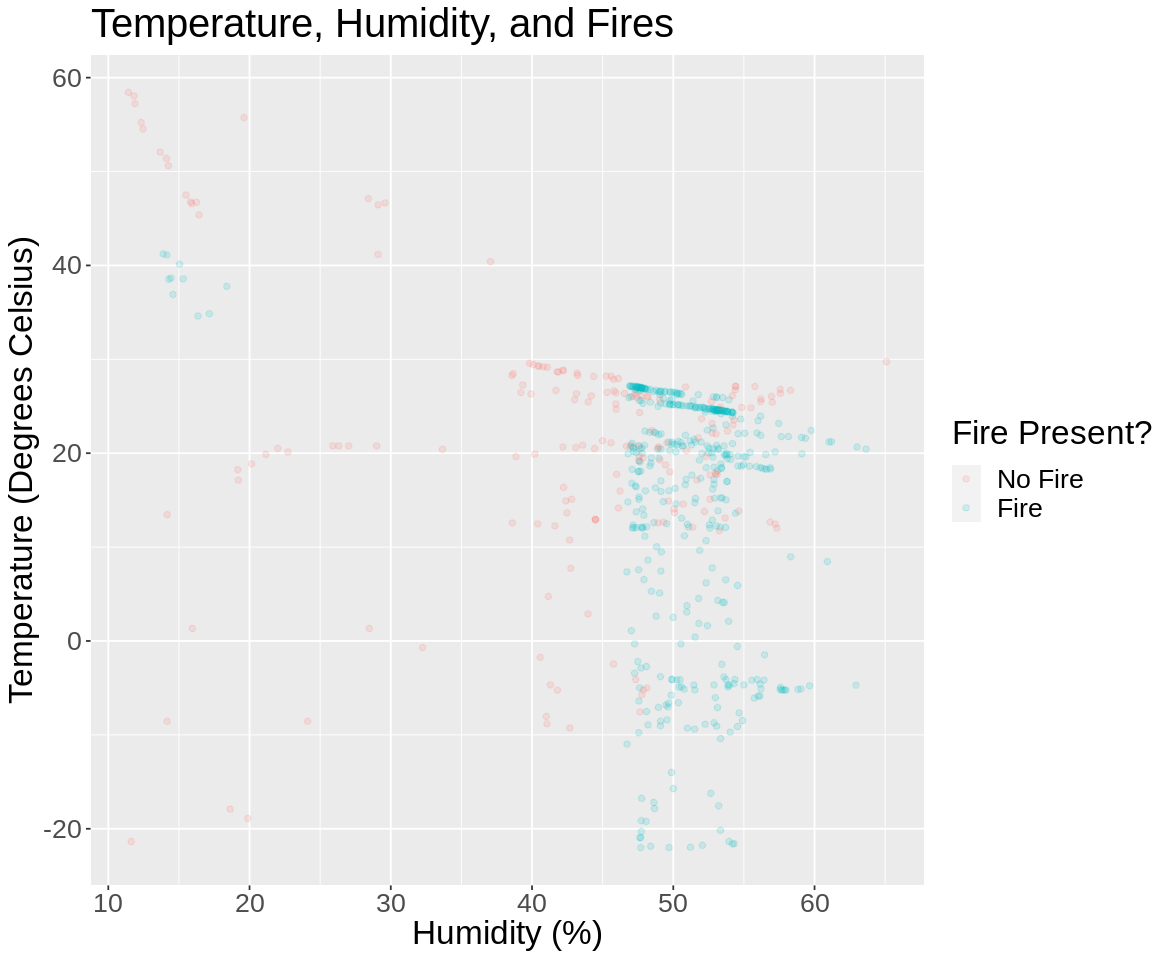

In [4]:
# Visualizations
options(repr.plot.width = 9.75, repr.plot.height = 8)
smoke_plot1 <- smoke_train |>
    ggplot(aes(x = humidity, y = raw_h2, color = fire)) +
    geom_point(alpha = 0.15) +
    ggtitle("Molecular Hydrogen, Humidity, and Fires") +
    labs(x = "Humidity (%)", y = "Raw Molecular Hydrogen", color = "Fire Present?") +
    theme(text = element_text(size = 20))
smoke_plot1

smoke_plot2 <- smoke_train |>
    ggplot(aes(x = humidity, y = temp, color = fire)) +
    geom_point(alpha = 0.15) +
    ggtitle("Temperature, Humidity, and Fires") +
    labs(x = "Humidity (%)", y = "Temperature (Degrees Celsius)", color = "Fire Present?") +
    theme(text = element_text(size = 20))
smoke_plot2

In [7]:
# Data analysis

# knn model to determine best k
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

smoke_recipe <- recipe(fire ~ ., data = smoke_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

smoke_vfold <- vfold_cv(smoke_train, v = 5, strata = fire)

k_vals = tibble(neighbors = seq(from = 1, to = 500, by = 50))

smoke_results <- workflow() |>
    add_model(knn_spec_tune) |>
    add_recipe(smoke_recipe) |>
    tune_grid(resamples = smoke_vfold, grid = k_vals) |>
    collect_metrics()


In [13]:
best_k <- smoke_results |>
    filter(.metric == "accuracy") |>
    arrange(by = mean) |>
    slice(1) |>
    pull(neighbors)
best_k

[1] 201

## Methods

We will attempt to use the K-nearest neighbors algorithm to predict whether or not a smoke detector reading represents an active fire, according to these steps:

1. Data Collection: Read data from remote GitHub repository containing the raw .csv file.

2. Data Preprocessing: Select relevant columns, and rename them to be more descriptive. Replace numerically-represented categorical variables with factors. Normalize and center the data, then split the preprocessed data into a training and testing set. 

3. Model Training: Train a KNN model on the training set by assigning a class label (fire or non-fire) to each data point based on its neighbors. We will use humidity, molecular hydrogen, and temperature for our analysis.

4. Model Evaluation: Use 5-fold cross validation to determine the value of K which maximizes precision. Estimate the accuracy of our model using the testing set we created earlier.

5. Visualizations and Conclusions: Create visualizations (decision boundary plots, scatter plots) and draw a conclusive answer to our predictive question: Can we predict whether there is an active fire based on a smoke alarm reading? Furthermore, how confident can we be in our predictions?

## Expected Outcomes and Significance

We expect to find that smoke alarm readings are a relatively accurate predictor of fires.

The variables we are analyzing are all related to fires: fires cause high temperatures and low humidity, and hydrogen is required in order to fuel combustion reactions. 
Our visualizations indicate that there are regions of values which contain exclusively fire/no fire readings, but other regions where both classes overlap. This may harm our model's accuracy.

These findings could help inform the designs of future smoke/fire detectors, and improve their accuracy.
Instead of detecting fire using only one variable, a future smoke detector could consider several variables and pass their values through our prediction model (if it is sufficiently accurate).

Some future questions include:
- Are there other, more relevant variables that should be considered in this analysis?
- Are there different prediction models that would yield greater results?
- Are there any biases in this data that skew our outcomes?